
# Comparing systematics and galaxy properties¶


This notebook serves as a validation test of the correlation between systematics and galaxy properties in Run 1.2i, based on the notebook contributed by Neha Joshi (@nehapjoshi) with Rachel Mandelbaum (@rmandelb)


In [2]:
import sys
sys.path.insert(-1, '/global/homes/z/zdu863/.conda/envs/py36/lib/python3.6/site-packages')

In [3]:
import healpy as hp
import numpy as np
import healsparse as hsp
import matplotlib.pyplot as plt

In [4]:
import GCRCatalogs
from GCR import GCRQuery

In [5]:
object_cat = GCRCatalogs.load_catalog('dc2_object_run1.2i_all_columns')

In [6]:
#Define necessary cuts to galaxy properties:
properties_cuts = [
    GCRQuery('mag_i_cModel < %f'%25.5)
]

# Establish some basic cuts intended to yield a galaxy sample with reasonable flux measurements.
basic_cuts = [
    GCRQuery('extendedness > 0'),     # Extended objects (primarily galaxies)
    GCRQuery((np.isfinite, 'mag_i_cModel')),  # Select objects that have i-band cmodel magnitudes
    GCRQuery('clean'), # The source has no flagged pixels (interpolated, saturated, edge, clipped...) 
                       # and was not skipped by the deblender
    GCRQuery('xy_flag == 0'),                                      # Flag for bad centroid measurement
]

# Cut out the DDF region
ddf_cut = [GCRQuery('(ra>55.5)*1+(dec<-30*1)>=1')]

In [7]:
#Define what properties we want to look at for the galaxy arrays:
quantities = ['ra', 'dec', 'mag_g_cModel', 'mag_i_cModel', 'mag_r_cModel', 'x', 'y']

In [8]:
#Apply cuts to catalog and get the wanted sample:
data = object_cat.get_quantities(quantities,
                                 filters=basic_cuts+properties_cuts+ddf_cut)

In [22]:
def plot_split(obs_data, gal_data, obs_title, gal_title, obs_xaxis, gal_xaxis):
    min_obs, max_obs = np.percentile(obs_data,(1,99)) #cuts of first and ninety-ninth percentile to remove outliers
    nbins = 100

    #plotting observational data:
    plt.figure(figsize=(20,10))
    plt.subplot(121)
    myrange = [min_obs,max_obs]
    plt.title(obs_title)
    plt.hist(obs_data, nbins, range=myrange, histtype='step',
            linewidth=2.0, density=True)
    plt.xlabel(obs_xaxis)
    plt.yscale('log')
    
    #setting up quartiles
    quartiles = np.percentile(obs_data,(1,25,50,75,99))
    plt.axvline(quartiles[1])
    plt.axvline(quartiles[2])
    plt.axvline(quartiles[3])
    
    min_gal, max_gal = np.percentile(gal_data,(1,99))
    
    #plotting observational data
    plt.subplot(122)
    labels = ['',
            '1st quartile',
             '2nd quartile',
             '3rd quartile',
             '4th quartile']
    
    myrange = [min_gal,max_gal]
    plt.title(gal_title)
    for q in range(1,len(quartiles)):
        data = gal_data[(obs_data<quartiles[q]) & (obs_data>=quartiles[q-1])]
        plt.hist(data, nbins, range=myrange, 
                 histtype='step', label=labels[q], linewidth=2.0, density=True)
    plt.legend(loc='upper right')
    plt.xlabel(gal_xaxis)
    plt.yscale('log')

In [30]:
b = 'i' #band name
hsp_mp = hsp.HealSparseMap.read('/global/projecta/projectdirs/lsst/groups/LSS/DC2_R1.2i/sysmaps/allmaps-%s.fits'%b) #Read the systematics maps
ra = data['ra']; dec = data['dec'];
obs_values = hsp_mp.getValueRaDec(ra, dec) #Get the systematics at the postition of each object

In [31]:
gr = data['mag_g_cModel'] - data['mag_r_cModel']
ri = data['mag_r_cModel'] - data['mag_i_cModel']

In [36]:
obs_titles = ['nvisit','airmass','rawSeeing','finSeeing','bg_mean','bg_var'] #name of the systematics
obs_data = [obs_values[obs_title] for obs_title in obs_titles]

gal_titles = ['g-r cmodel color', 'r-i cmodel color', 'i-band cmodel magnitude']
gal_data = [gr, ri, data['mag_i_cModel']]

obs_xaxis = ['', '', '', '', '','']
gal_xaxis = ['g-r color', 'r-i color', 'i mag']

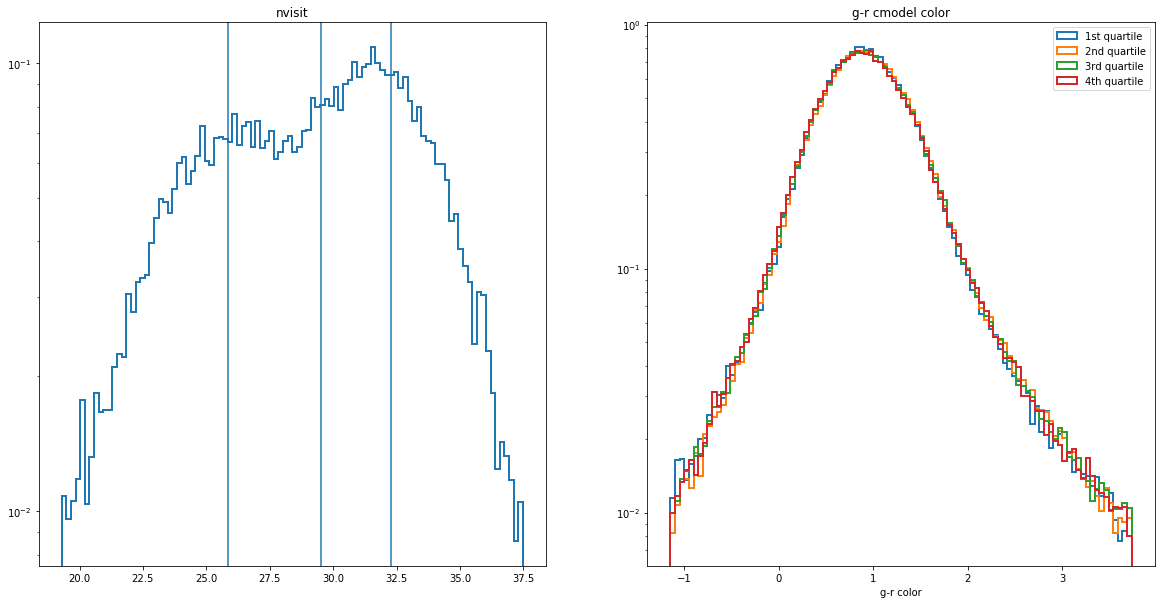

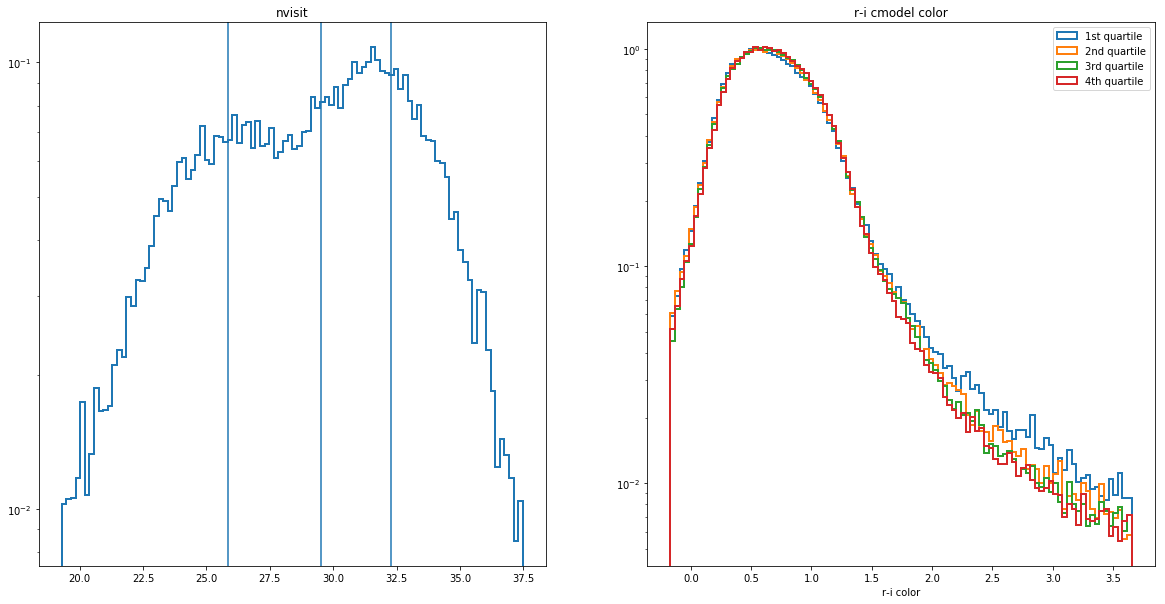

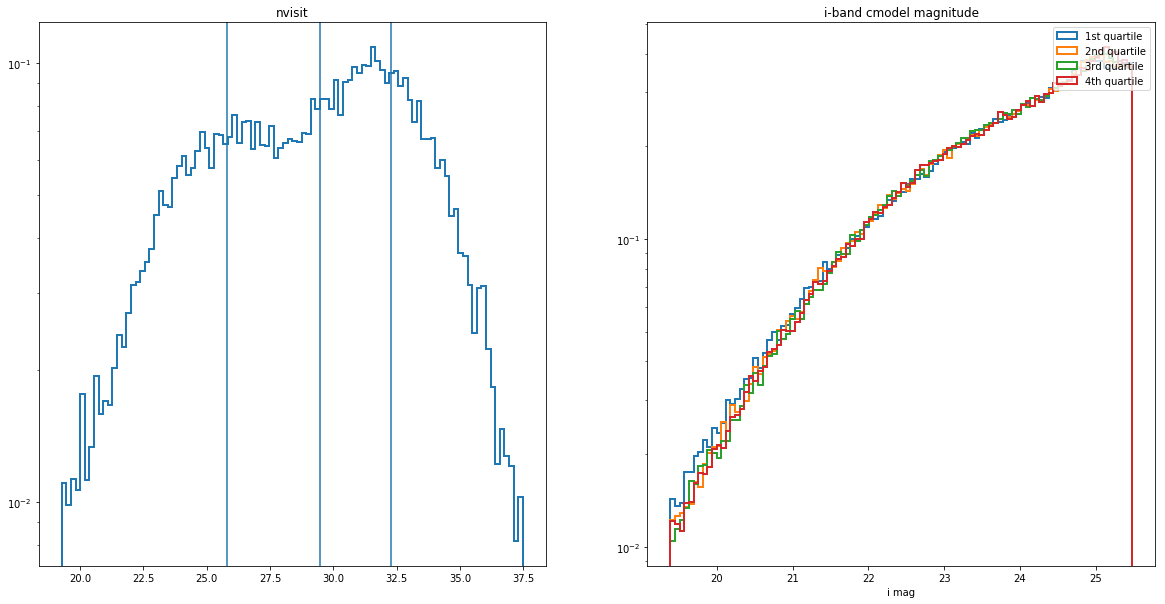

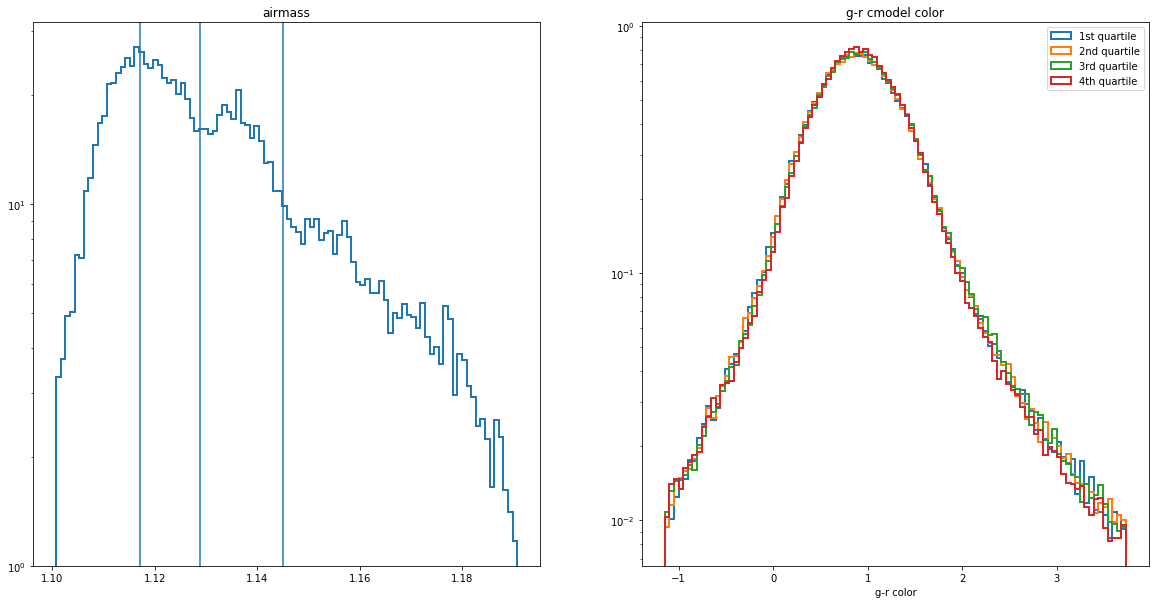

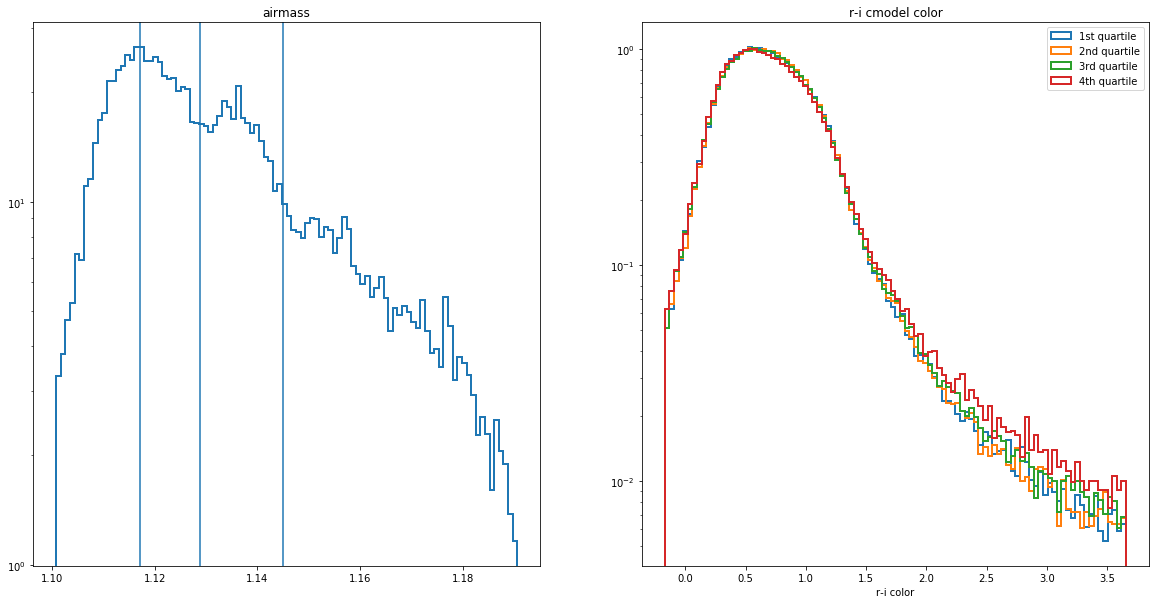

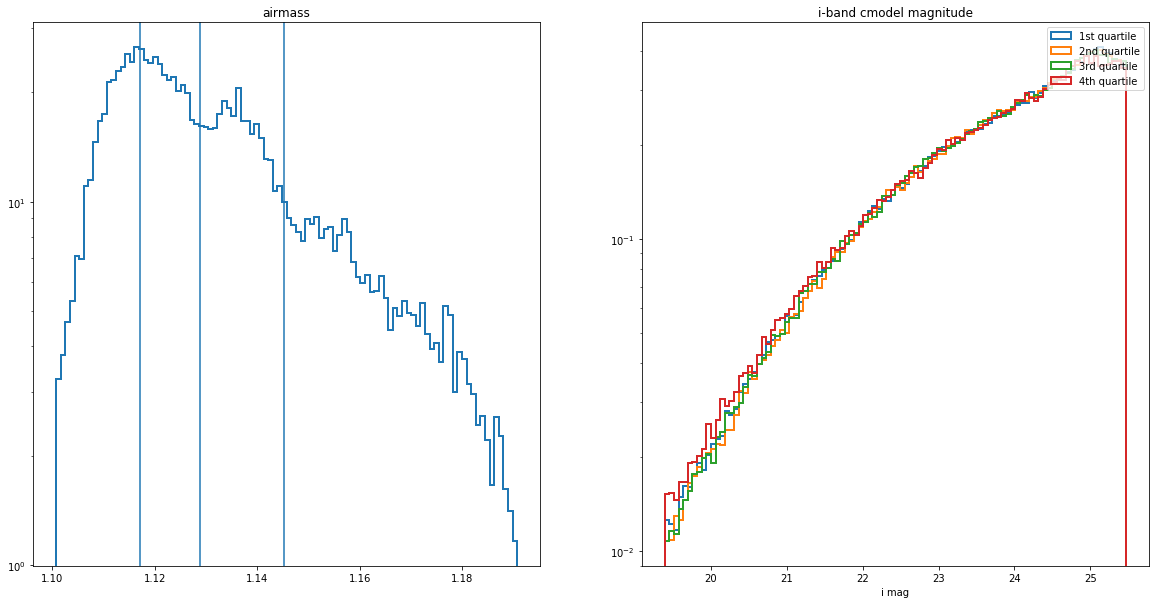

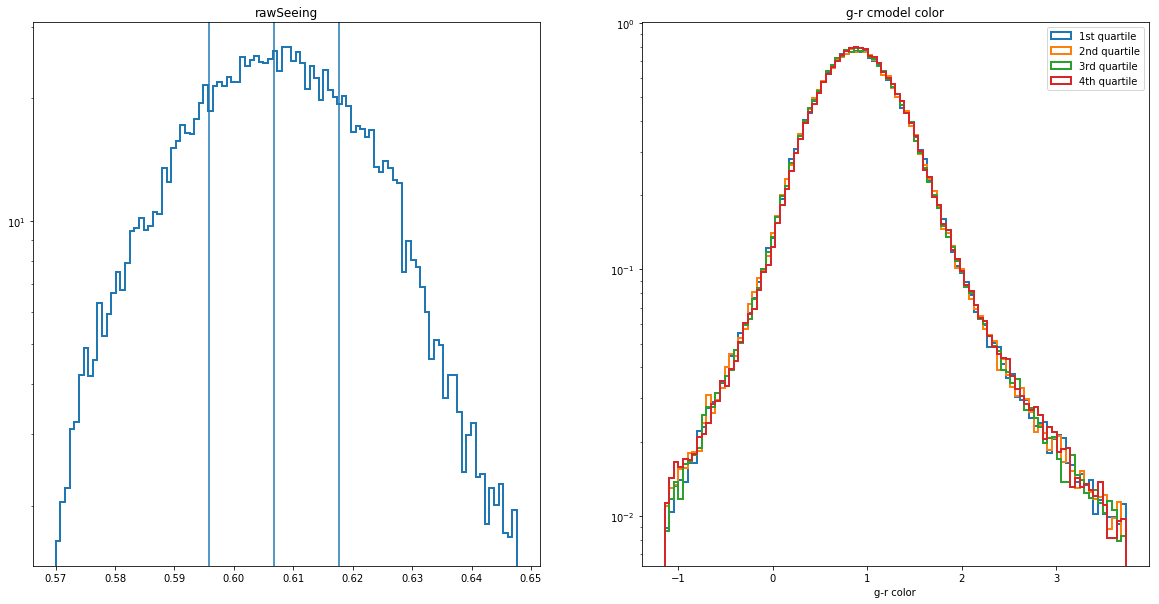

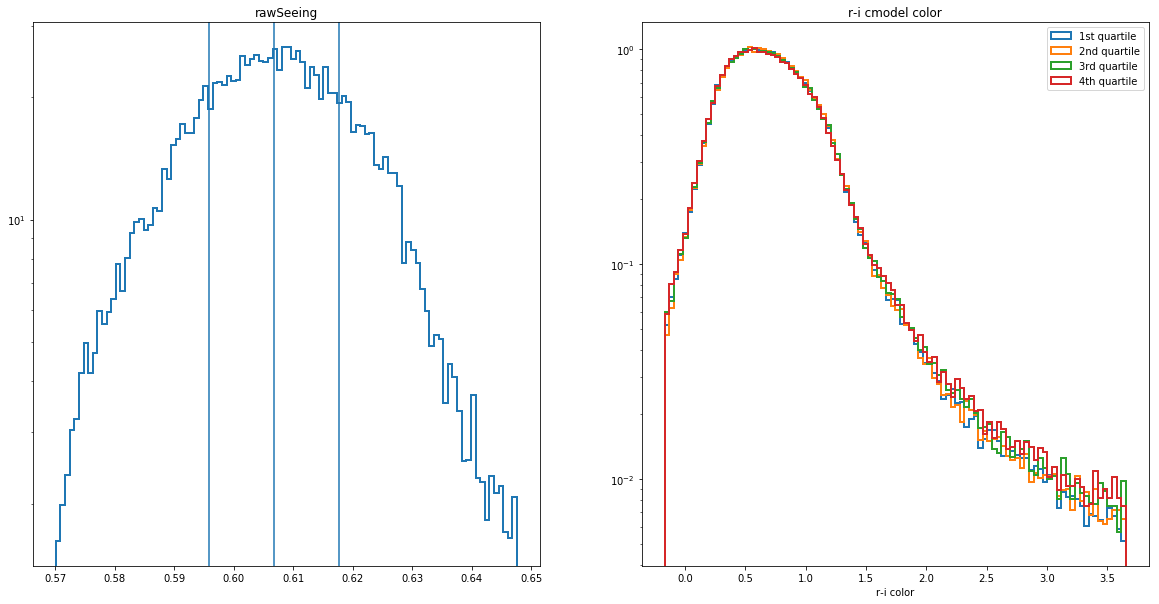

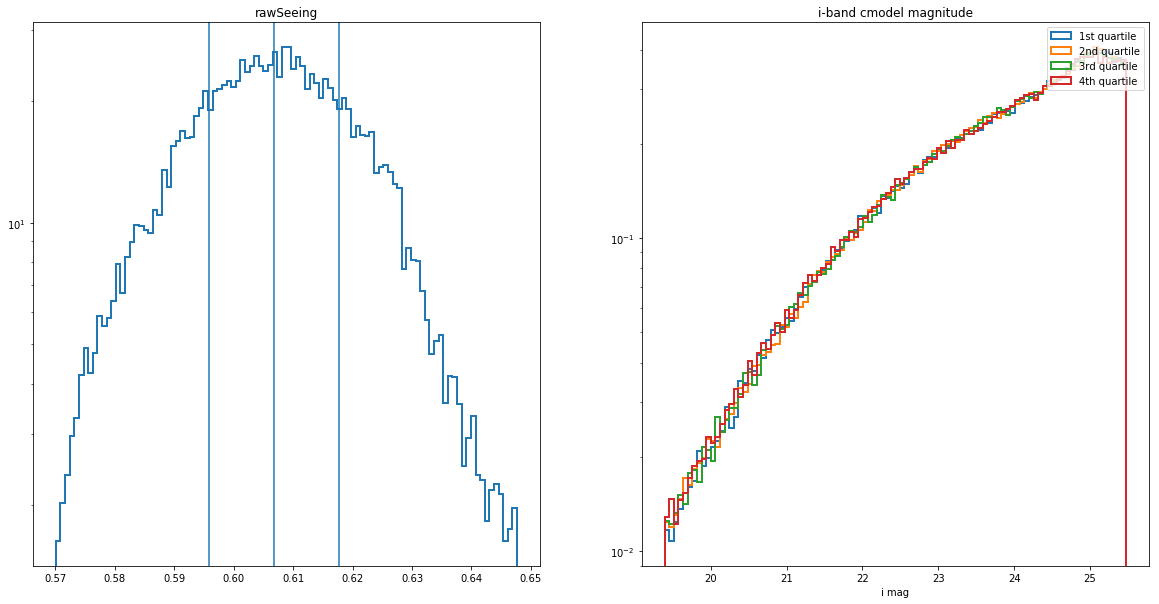

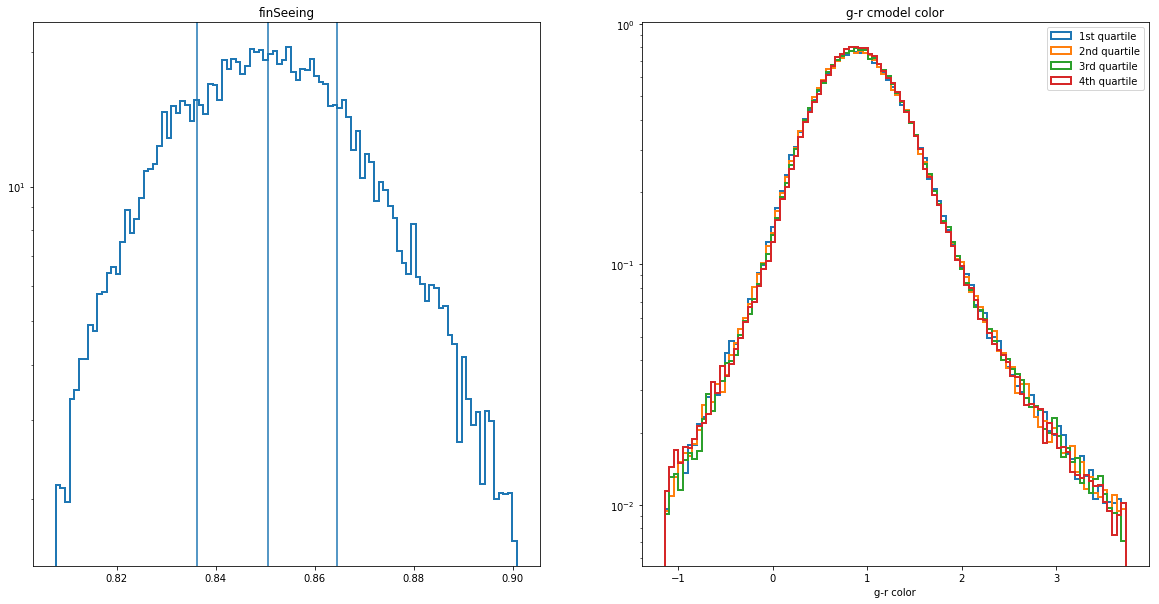

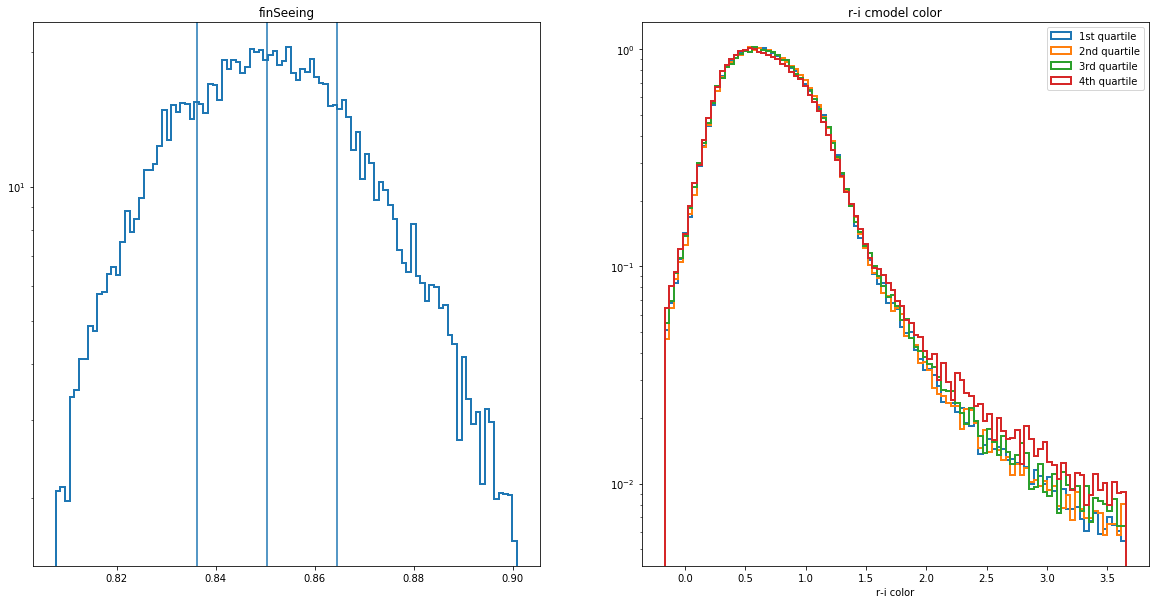

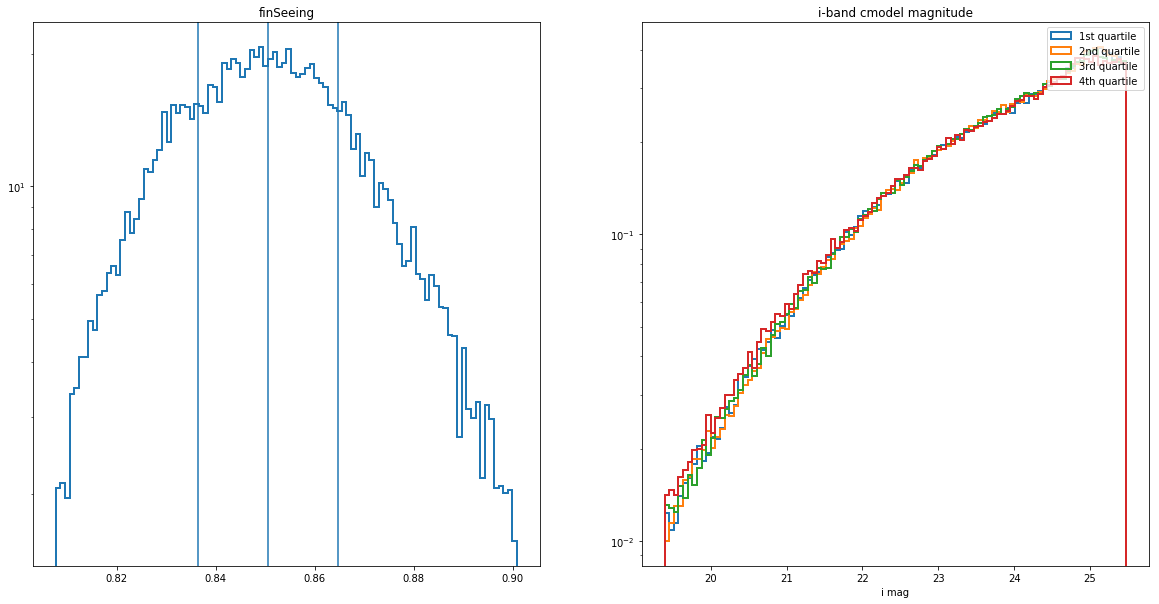

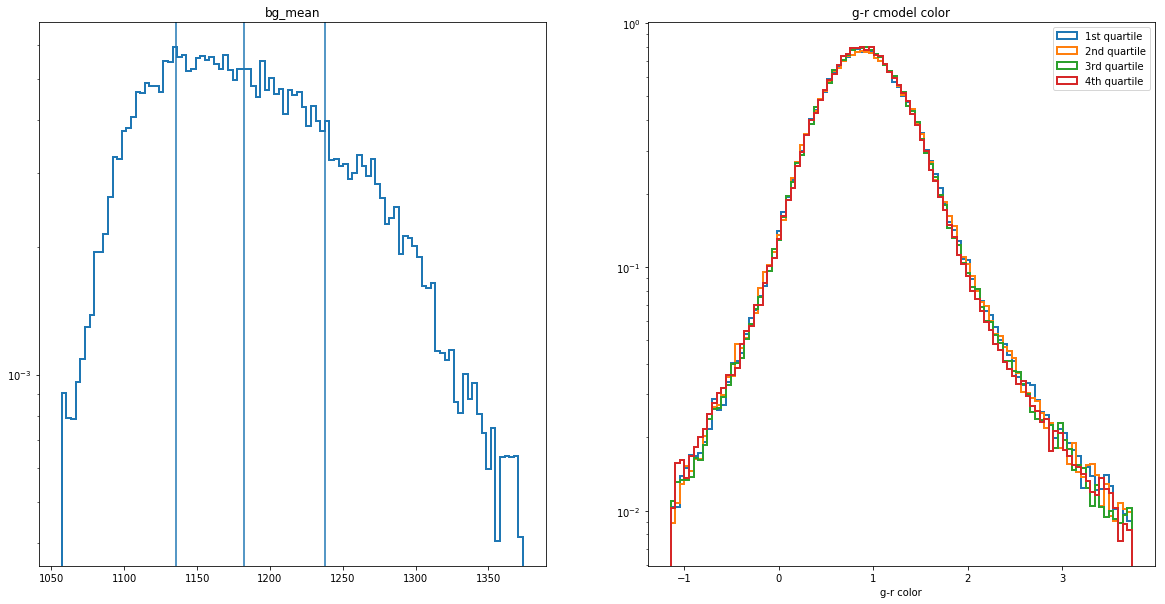

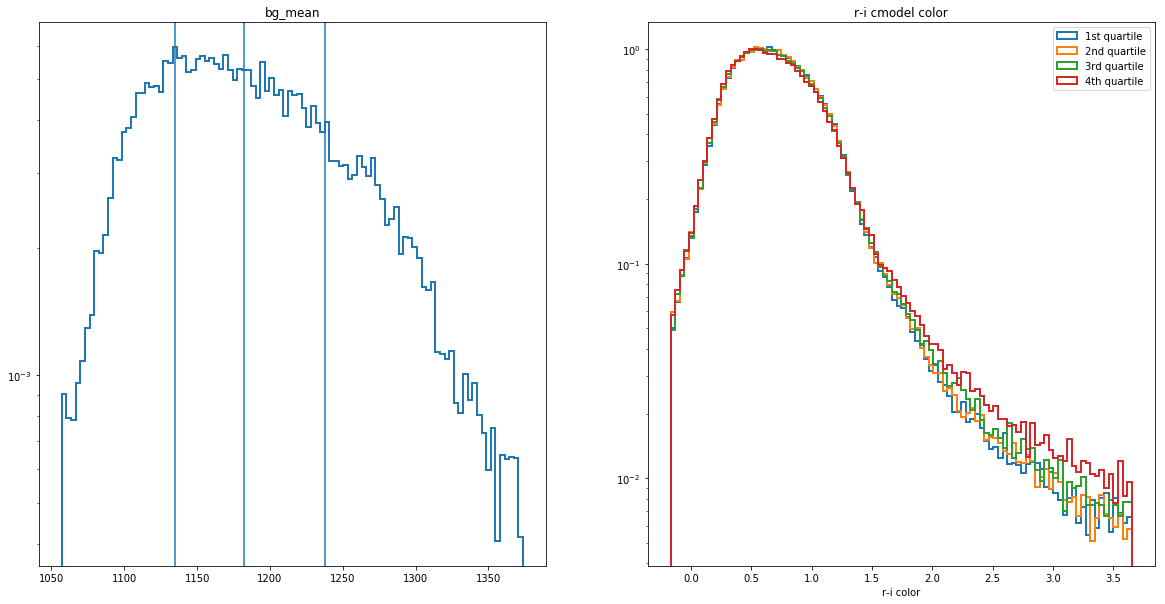

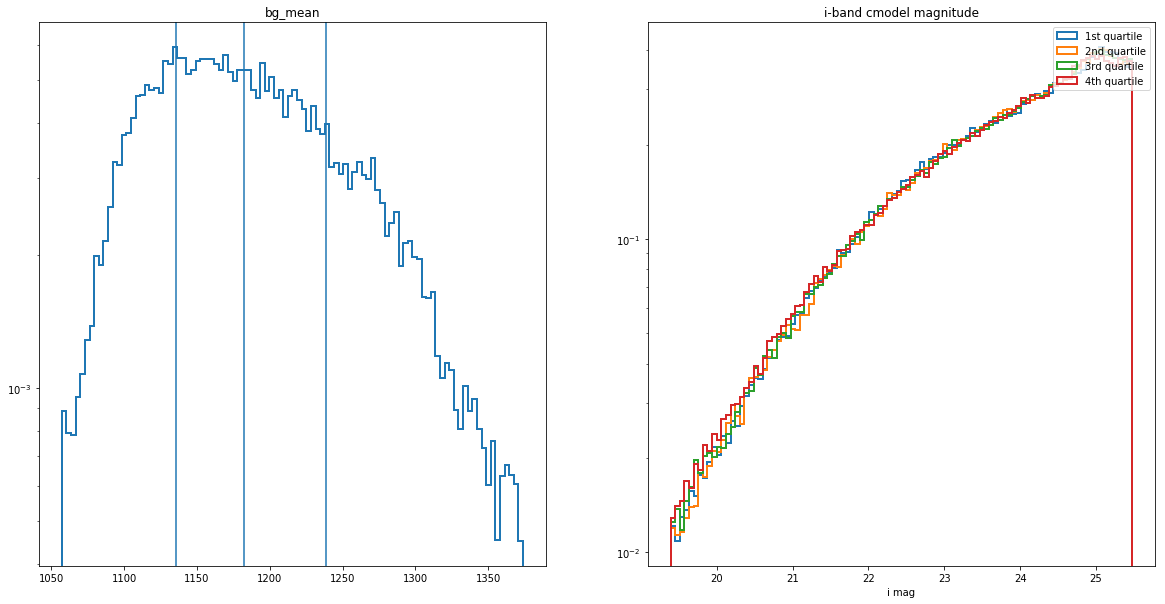

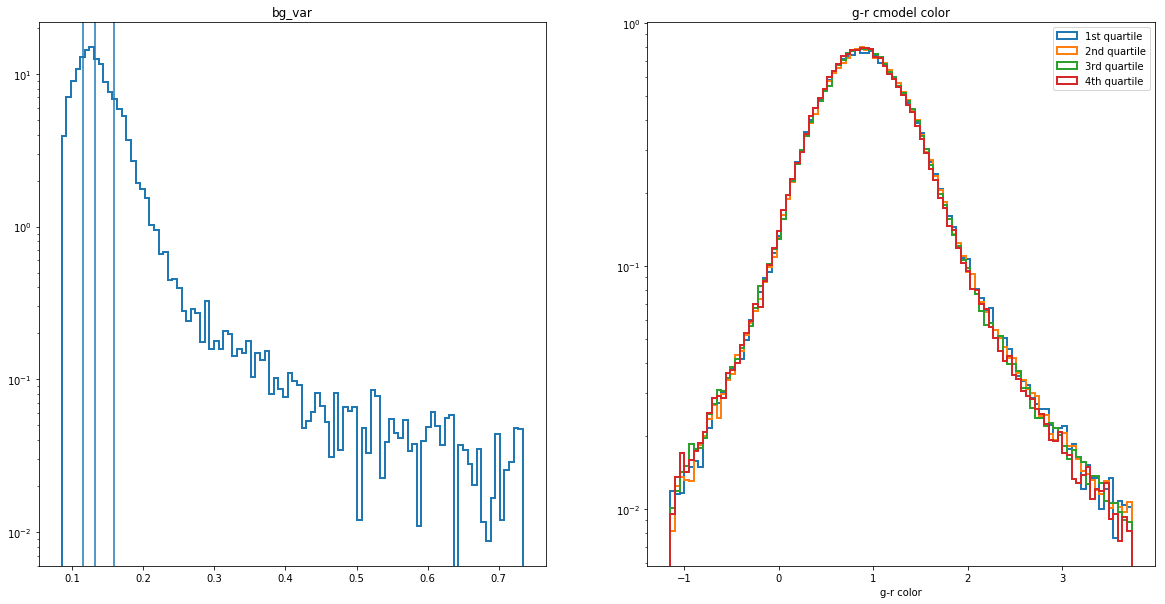

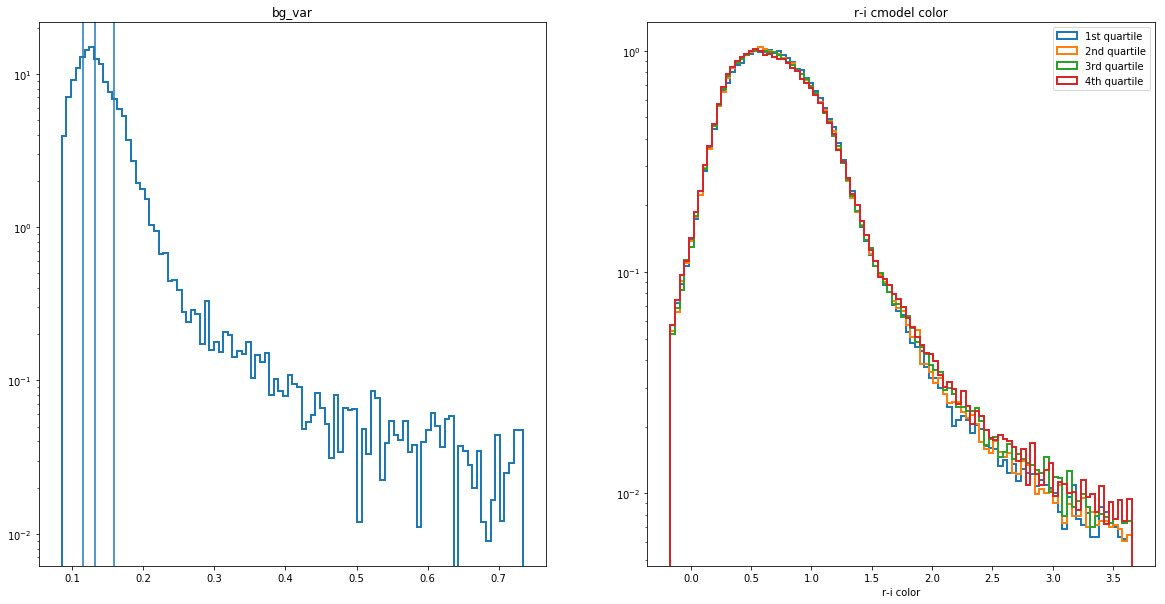

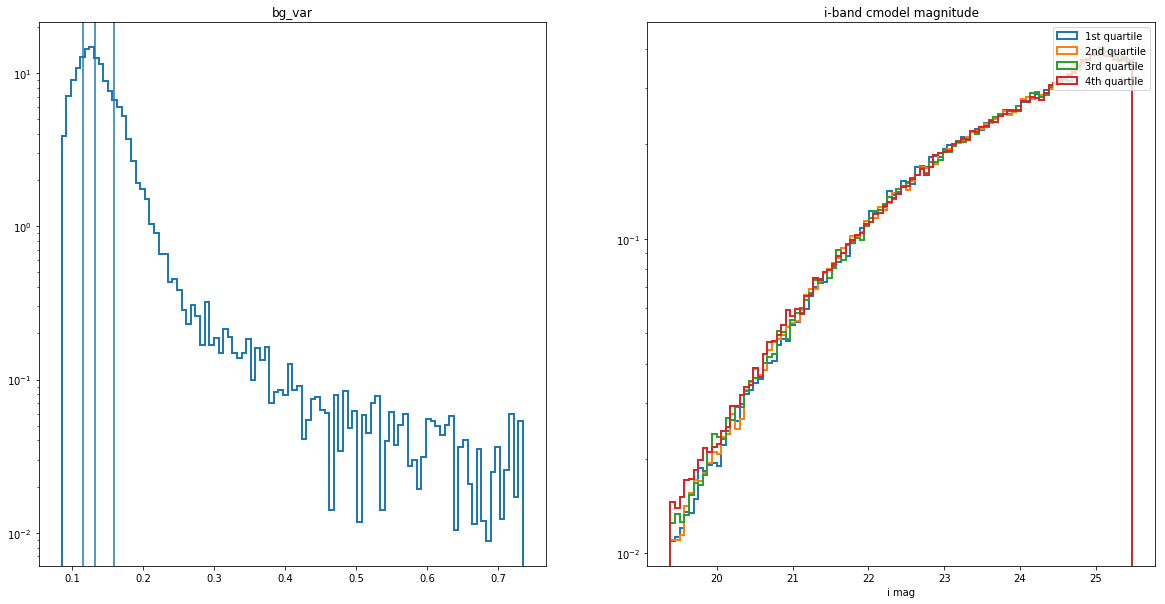

In [37]:
for obs in range(len(obs_data)):
    for gal in range(len(gal_data)):
        good_data = ~np.isnan(obs_data[obs]) & ~np.isnan(gal_data[gal]) & ~(obs_data[obs]<-99999) # remove nans and hp.UNSEEN values
        plot_split(obs_data[obs][good_data],gal_data[gal][good_data],
                   obs_titles[obs], gal_titles[gal], 
                   obs_xaxis[obs], gal_xaxis[gal])